In [55]:
import yfinance as yf
import pandas as pd
pd.options.display.max_rows = None

In [56]:
import requests
from io import StringIO

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url, headers=headers)
sp500 = pd.read_html(StringIO(response.text))[0]

# Then your filtering code
it_companies = sp500[sp500['GICS Sector'] == 'Information Technology']

In [57]:
# Extract tickers list from your dataframe
it_tickers = it_companies['Symbol'].tolist()

# Empty list to collect revenue data
all_data = []

for ticker in it_tickers:
    stock = yf.Ticker(ticker)
    try:
        income_stmt = stock.financials
        
        # Get Total Revenue row
        revenue = income_stmt.loc['Total Revenue']
        
        # Convert index (which are dates) into year
        revenue.index = revenue.index.year
        
        # Sort years descending (latest first)
        revenue = revenue.sort_index(ascending=False)
        
        # Keep only last 3 years
        revenue_last3 = revenue.head(3)
        
        # Create dict with ticker and revenues
        data_row = {'Ticker': ticker}
        data_row.update(revenue_last3.to_dict())
        
        all_data.append(data_row)
        
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

# Convert list of dicts into dataframe
revenue_df = pd.DataFrame(all_data)

# Reorder columns: Ticker first, then years
cols = ['Ticker'] + sorted([col for col in revenue_df.columns if col != 'Ticker'], reverse=True)
revenue_df = revenue_df[cols]

# Display final clean data
print(revenue_df)

   Ticker          2025          2024          2023          2022
0     ACN           NaN  6.489646e+10  6.411174e+10  6.159430e+10
1    ADBE           NaN  2.150500e+10  1.940900e+10  1.760600e+10
2     AMD           NaN  2.578500e+10  2.268000e+10  2.360100e+10
3    AKAM           NaN  3.991168e+09  3.811920e+09  3.616654e+09
4     APH           NaN  1.522270e+10  1.255470e+10  1.262300e+10
5     ADI           NaN  9.427157e+09  1.230554e+10  1.201395e+10
6    AAPL           NaN  3.910350e+11  3.832850e+11  3.943280e+11
7    AMAT           NaN  2.717600e+10  2.651700e+10  2.578500e+10
8     APP           NaN  4.709248e+09  3.283087e+09  2.817058e+09
9    ANET           NaN  7.003146e+09  5.860168e+09  4.381310e+09
10   ADSK  6.131000e+09  5.497000e+09  5.005000e+09           NaN
11   AVGO           NaN  5.157400e+10  3.581900e+10  3.320300e+10
12   CDNS           NaN  4.641264e+09  4.089986e+09  3.561718e+09
13    CDW           NaN  2.099870e+10  2.137600e+10  2.374870e+10
14   CSCO 

In [58]:
revenue_df_cleaned = revenue_df

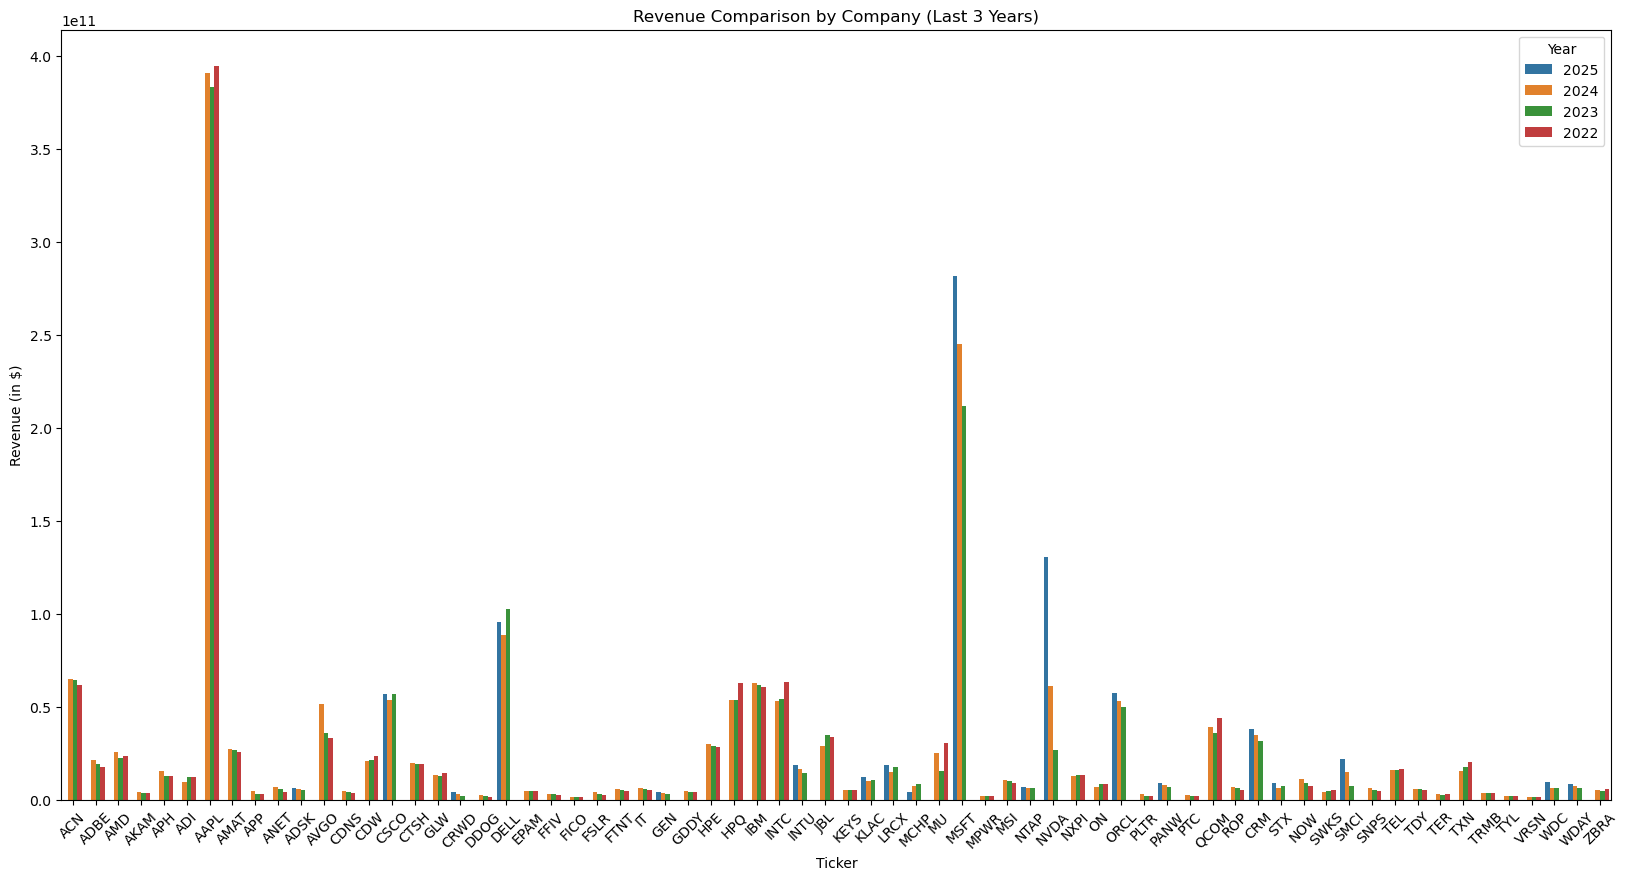

In [59]:
import matplotlib.pyplot as plt

# First, reshape the data for plotting (melt)
df_melted = revenue_df_cleaned.melt(id_vars=['Ticker'], var_name='Year', value_name='Revenue')

# Convert year to string for better plotting
df_melted['Year'] = df_melted['Year'].astype(str)

# Plot grouped bar chart
plt.figure(figsize=(20, 10))

# Use seaborn for better looking plot (optional)
import seaborn as sns
sns.barplot(data=df_melted, x='Ticker', y='Revenue', hue='Year')

plt.title("Revenue Comparison by Company (Last 3 Years)")
plt.ylabel("Revenue (in $)")
plt.xticks(rotation=45)
plt.show()

In [60]:

# Assuming your it_companies DataFrame is already loaded
it_tickers = it_companies['Symbol'].tolist()

all_data = []

for ticker in it_tickers:
    stock = yf.Ticker(ticker)
    try:
        income_stmt = stock.financials
        
        # Extract Net Income instead of Total Revenue
        profit = income_stmt.loc['Net Income']
        
        # Convert index to year
        profit.index = profit.index.year
        
        # Sort by year
        profit = profit.sort_index(ascending=False)
        
        # Take last 3 years
        profit_last3 = profit.head(3)
        
        # Build row
        data_row = {'Ticker': ticker}
        data_row.update(profit_last3.to_dict())
        all_data.append(data_row)
        
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

# Convert to dataframe
profit_df = pd.DataFrame(all_data)


In [61]:
profit_df_cleaned = profit_df

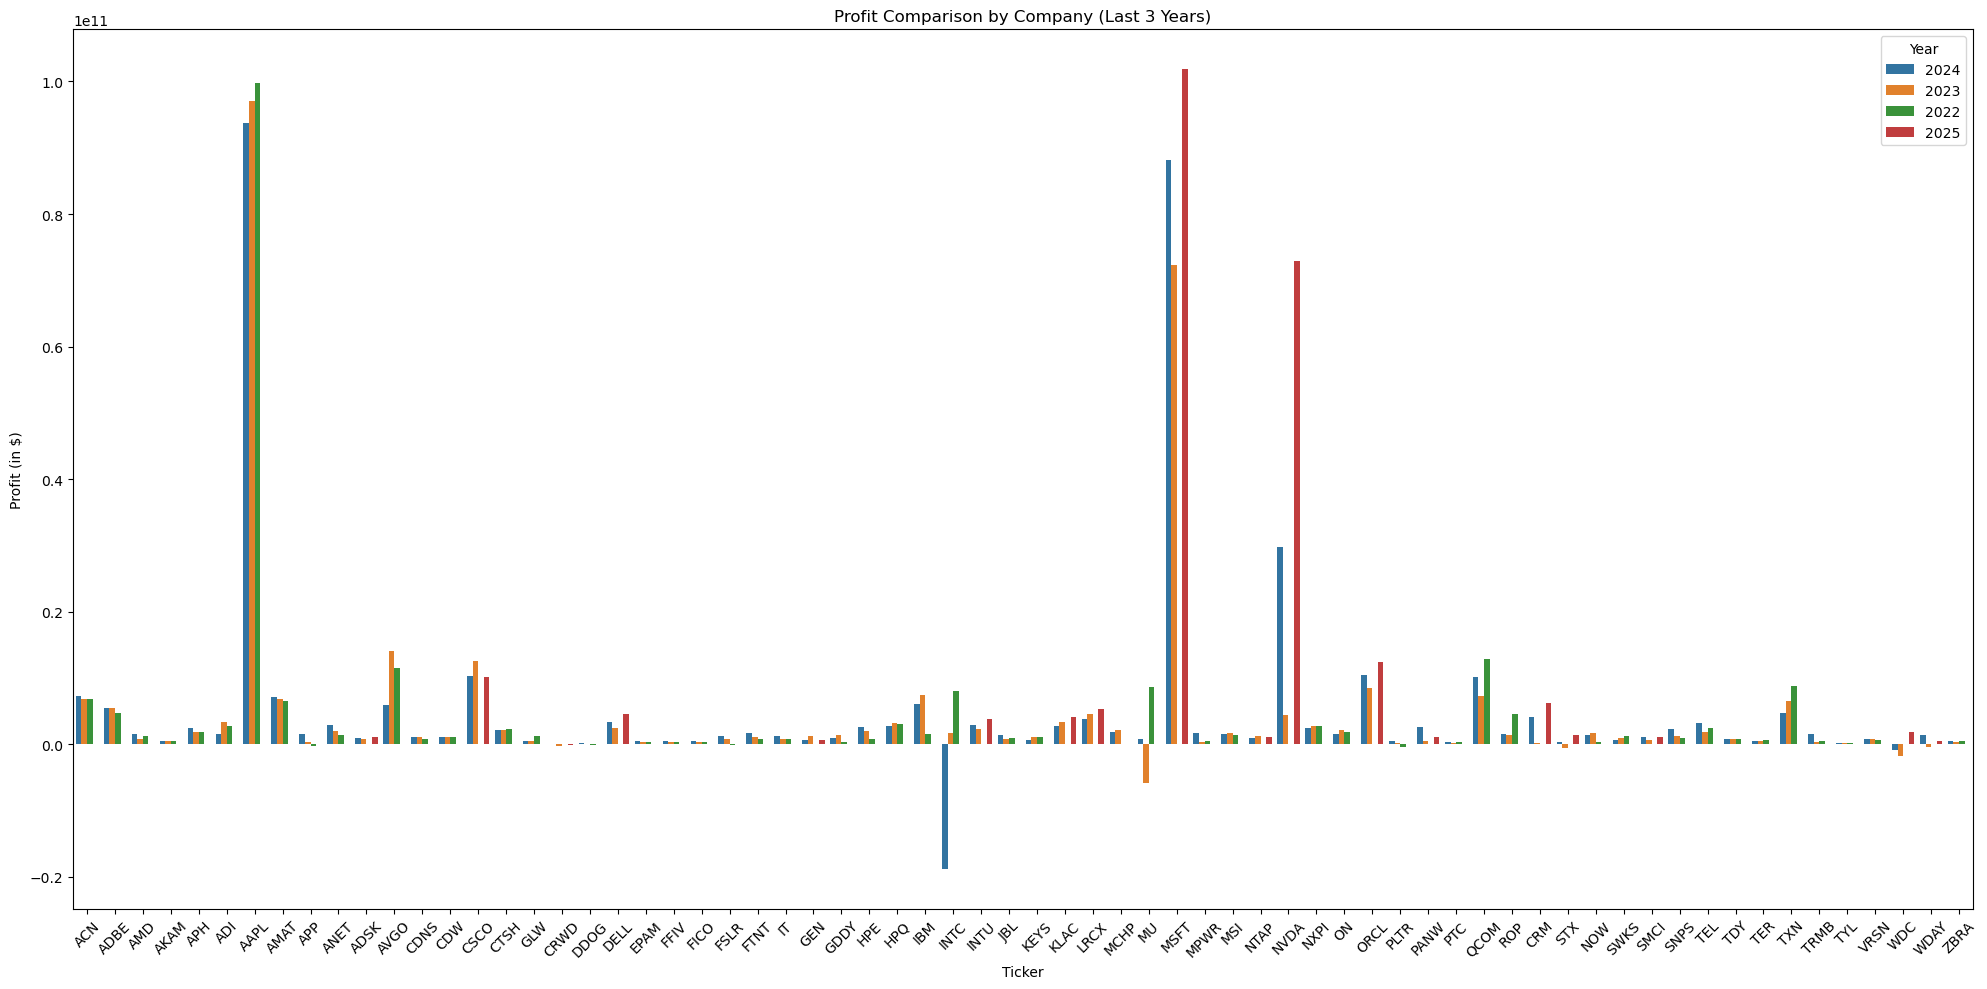

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt for visualization
profit_melted = profit_df_cleaned.melt(id_vars=['Ticker'], var_name='Year', value_name='Profit')
profit_melted['Year'] = profit_melted['Year'].astype(str)

# Plot
plt.figure(figsize=(20, 10))
sns.barplot(data=profit_melted, x='Ticker', y='Profit', hue='Year')
plt.title("Profit Comparison by Company (Last 3 Years)")
plt.ylabel("Profit (in $)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
# Extract tickers from your dataframe
it_tickers = it_companies['Symbol'].tolist()

# Collect all data
all_data = []

for ticker in it_tickers:
    stock = yf.Ticker(ticker)
    try:
        income_stmt = stock.financials

        # Extract required fields
        revenue = income_stmt.loc['Total Revenue']
        net_income = income_stmt.loc['Net Income']
        gross_profit = income_stmt.loc['Gross Profit']

        # Convert index to year
        revenue.index = revenue.index.year
        net_income.index = net_income.index.year
        gross_profit.index = gross_profit.index.year

        # Combine all into single dataframe for proper alignment
        df = pd.concat(
            [revenue, gross_profit, net_income], 
            axis=1, 
            keys=['Revenue', 'Gross Profit', 'Net Income']
        )

        # Keep only latest 3 years
        df = df.sort_index(ascending=False).head(3)

        # Drop rows with any missing values (Revenue, Gross Profit, Net Income)
        df = df.dropna()

        # Now calculate margins
        for year, row in df.iterrows():
            data_row = {
                'Ticker': ticker,
                'Year': year,
                'Revenue': row['Revenue'],
                'Gross Profit': row['Gross Profit'],
                'Net Income': row['Net Income'],
                'Gross Profit Margin %': (row['Gross Profit'] / row['Revenue']) * 100 if row['Revenue'] != 0 else None,
                'Net Income Margin %': (row['Net Income'] / row['Revenue']) * 100 if row['Revenue'] != 0 else None
            }
            all_data.append(data_row)

    except Exception as e:
        print(f"Failed for {ticker}: {e}")

# Create final dataframe
margins_df = pd.DataFrame(all_data)

# Sort final dataframe by Ticker and Year descending
margins_df = margins_df.sort_values(by=['Ticker', 'Year'], ascending=[True, False])

# Display clean final dataset
print(margins_df)


    Ticker  Year       Revenue  Gross Profit    Net Income  \
18    AAPL  2024  3.910350e+11  1.806830e+11  9.373600e+10   
19    AAPL  2023  3.832850e+11  1.691480e+11  9.699500e+10   
20    AAPL  2022  3.943280e+11  1.707820e+11  9.980300e+10   
0      ACN  2024  6.489646e+10  2.116232e+10  7.264787e+09   
1      ACN  2023  6.411174e+10  2.073161e+10  6.871557e+09   
2      ACN  2022  6.159430e+10  1.970154e+10  6.877169e+09   
3     ADBE  2024  2.150500e+10  1.914700e+10  5.560000e+09   
4     ADBE  2023  1.940900e+10  1.705500e+10  5.428000e+09   
5     ADBE  2022  1.760600e+10  1.544100e+10  4.756000e+09   
15     ADI  2024  9.427157e+09  5.381343e+09  1.635273e+09   
16     ADI  2023  1.230554e+10  7.877218e+09  3.314579e+09   
17     ADI  2022  1.201395e+10  7.532474e+09  2.748561e+09   
30    ADSK  2025  6.131000e+09  5.553000e+09  1.112000e+09   
31    ADSK  2024  5.497000e+09  4.986000e+09  9.060000e+08   
32    ADSK  2023  5.005000e+09  4.525000e+09  8.230000e+08   
9     AK

<Figure size 1000x600 with 0 Axes>

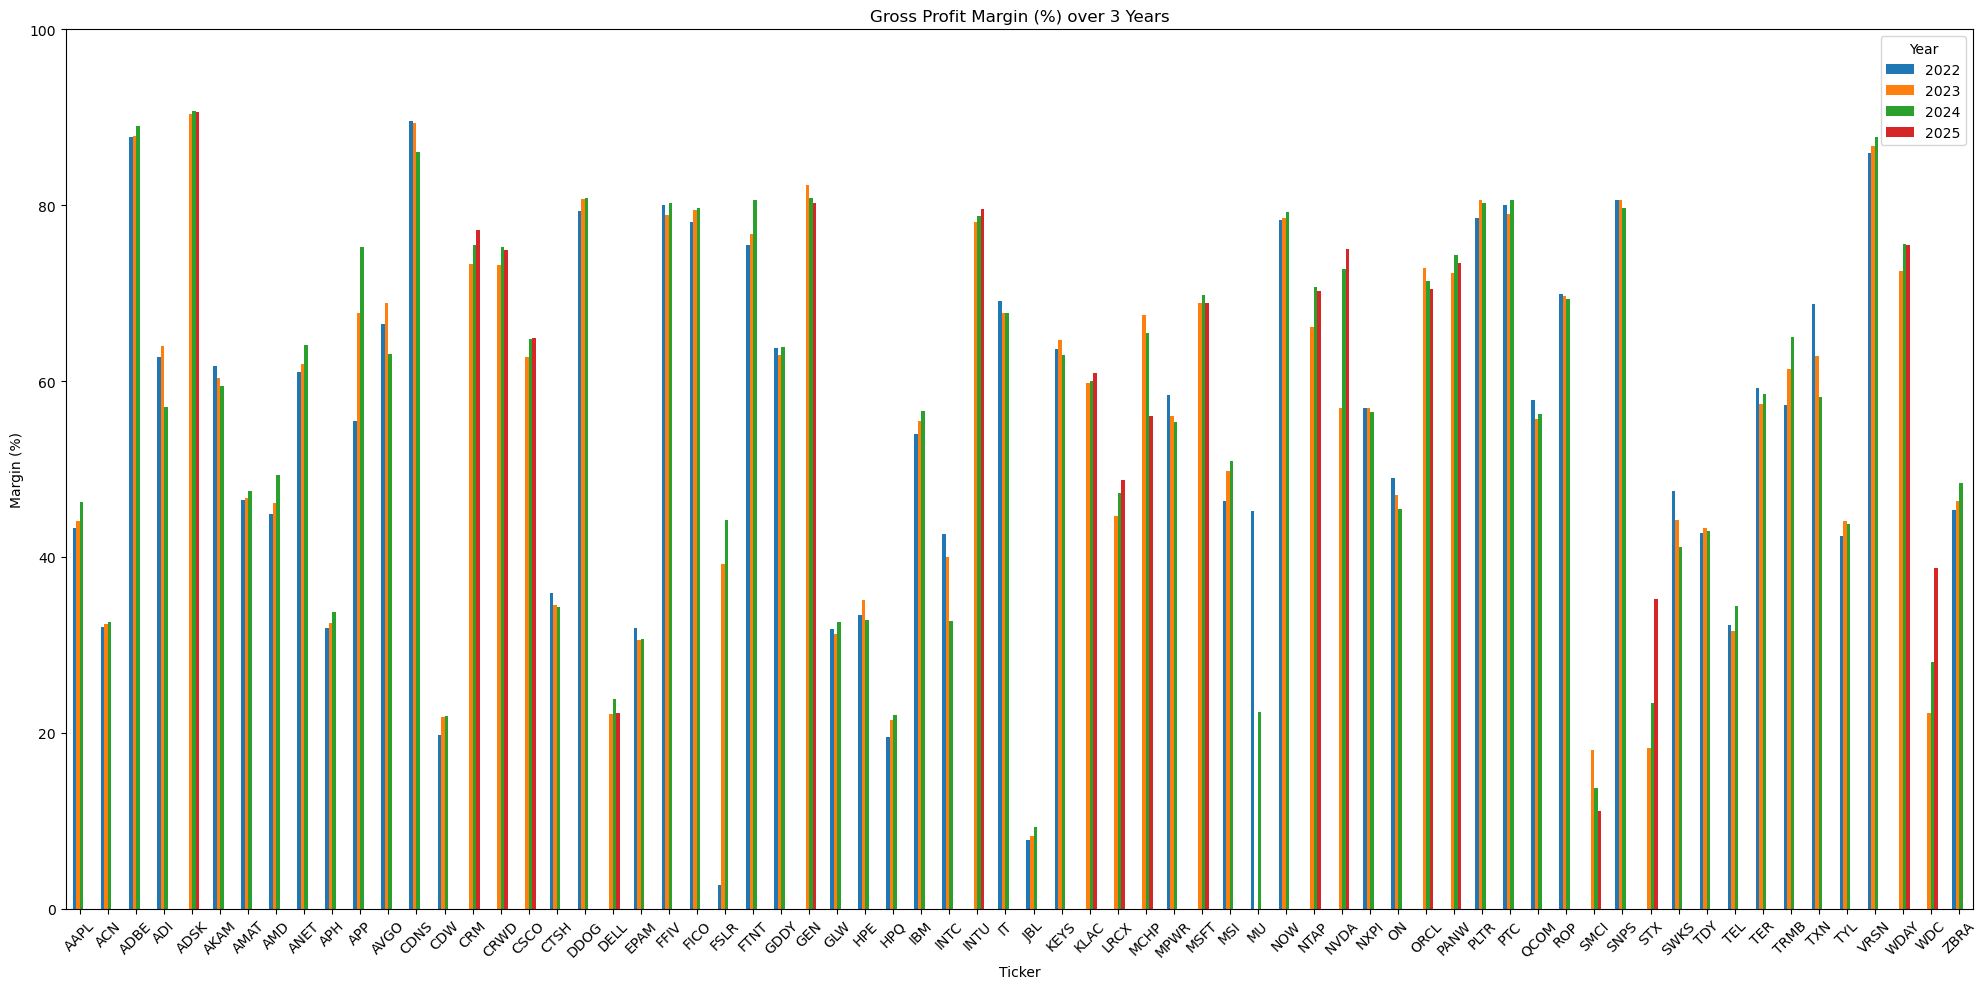

<Figure size 1000x600 with 0 Axes>

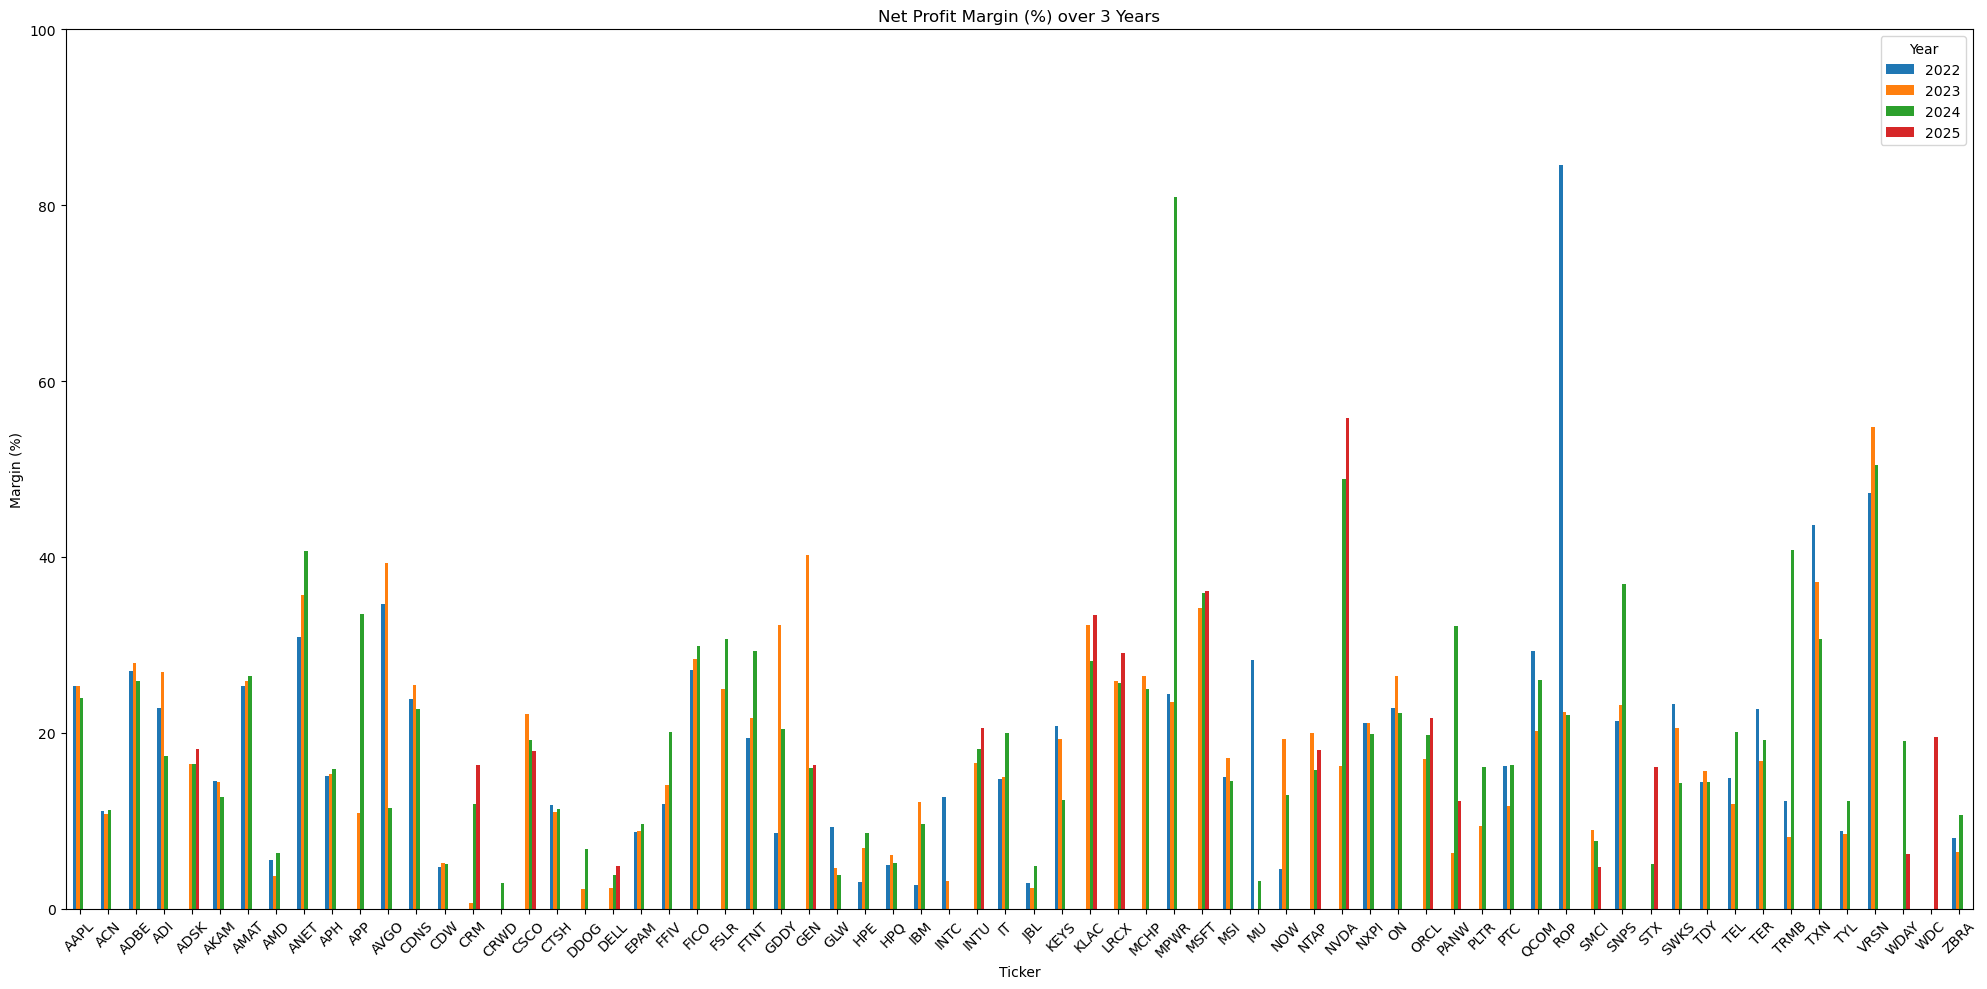

In [64]:
# First: Prepare Gross Profit Margin data
gp_df = margins_df.pivot(index='Ticker', columns='Year', values='Gross Profit Margin %')

# Second: Prepare Net Profit Margin data
np_df = margins_df.pivot(index='Ticker', columns='Year', values='Net Income Margin %')

# Plot Gross Profit Margin
plt.figure(figsize=(10, 6))
gp_df.plot(kind='bar', figsize=(20, 10))
plt.title('Gross Profit Margin (%) over 3 Years')
plt.ylabel('Margin (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

# Plot Net Profit Margin
plt.figure(figsize=(10, 6))
np_df.plot(kind='bar', figsize=(20, 10))
plt.title('Net Profit Margin (%) over 3 Years')
plt.ylabel('Margin (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title='Year')
plt.tight_layout()
plt.show()
